### Python Script to Compute Mann Kendall trends written by Herbert. O. Misiani and modified by Samuel Ekwacu

### Computing persistent hot spell events trends over Africa-Seasonal

In [1]:
## libraries to install for first time 
#conda install -c conda-forge regionmask
# conda install -c conda-forge geopandas
#conda install -c conda-forge descartes
#conda install -c conda-forge pymannkendall
#conda install -c conda-forge cartopy
#conda install -c conda-forge pyogrio
#conda install -c conda-forge xeofs
#conda install -c conda-forge r-correlation
#conda install -c conda-forge pytest-regressions

In [1]:
#conda install -c main cartopy

In [4]:
import pymannkendall as mk
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from descartes import PolygonPatch
import matplotlib.path as mplPath
from shapely.geometry.polygon import Polygon
import geopandas as gpd
import shapefile as shp
import regionmask
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib as mpl
from matplotlib.colors import ListedColormap

ImportError: cannot import name lgeos

In [120]:
dh = xr.open_dataset('C:/Diabatic_data/extra3/total_precip_1961-2021_mon.nc')
#dh               
dh.data_vars

Data variables:
    total_precip  (time, lat, lon) float32 ...

In [121]:
#dh.lev  # print presure level
#dh = dh.sel(lev=95000) #selecting to the pressure level
#wspd

In [122]:
#dh = dh.sel(time=slice("1991-01-01", "2021-12-01"))

In [123]:
dh.coords['lon']=(dh.coords['lon']+180)%360-180
dh=dh.sortby(dh.lon) 

In [124]:
###For Annual Trends Only
Data =dh['total_precip'].groupby('time.year').mean('time')    ## Group data into yearly means for annual trends
#dat_samp
#Data

In [125]:
#dat_samp = Data.sel(lon=slice(27.5, 42.5), lat=slice(-12, 5))  ## Slice to EA
dat_samp = Data.sel(lon=slice(-20, 55), lat=slice(40, -35))  ## Slice to Africa
slope_val = np.zeros((len(dat_samp.lat.values),len(dat_samp.lon.values)))
p_value = np.zeros((len(dat_samp.lat.values),len(dat_samp.lon.values)))
#output = []
for i in np.arange(len(dat_samp.lat.values)):
    for j in np.arange(len(dat_samp.lon.values)):
        
        try:
            slope_val[i,j] = mk.original_test(dat_samp[:,i,j]).slope  ## trend,h,p,z,tau,s,var_s,slope,intercept = mk.original_test(x,0.05)
            p_value[i,j] = mk.original_test(dat_samp[:,i,j]).p
        except:
            slope_val[i,j] = np.nan
            p_value[i,j] = np.nan
            
        #output.append(slope_val)

In [126]:
## Define data as Xarray dataset and save as netcdf
output1=xr.DataArray(slope_val, dims=('lat', 'lon'), coords={'lat':dat_samp.lat, 'lon':dat_samp.lon}, attrs=dict(description="slope.", units="sst year-1"),)
data1 = output1.rename("trend")

output2=xr.DataArray(p_value, dims=('lat', 'lon'), coords={'lat':dat_samp.lat, 'lon':dat_samp.lon}, attrs=dict(description="significance",),)
data2 = output2.rename("p_val")
#data2
## Save Data as netcdf
#data1.to_netcdf('C:/Diabatic_data/Af_CNHR_1991-2021_Annual_trend.nc', mode='w')
#data2.to_netcdf('C:/Diabatic_data/Af_CNHR_1991-2021_Annual_pvalue.nc', mode='w')
#data1

In [127]:
## clip the data with the mask
trnd = data1
pval = data2
#trnd

C:\Users\Samuel-NUIST\AppData\Local\Temp\ipykernel_9852\3690342194.py:7: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.gcf().subplots_adjust(hspace=0, wspace=0.08)


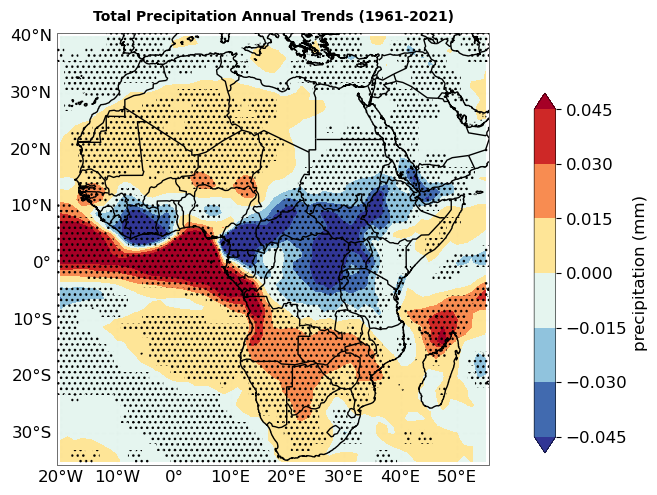

In [130]:
#Plot the map
none_map = ListedColormap(['none'])
fig = plt.subplots(constrained_layout=True, figsize=(12, 6))
mpl.rcParams['font.family'] #= 'Times New Roman'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 0.4
plt.gcf().subplots_adjust(hspace=0, wspace=0.08)
ax = plt.subplot(projection=ccrs.PlateCarree(central_longitude=0))

gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.01, linestyle='--')
gl.xlabels_top = False; gl.ylabels_left = True; gl.ylabels_right=False; gl.xlines = True
gl.xformatter = LONGITUDE_FORMATTER; gl.yformatter = LATITUDE_FORMATTER

## Change this to the threshold you need.
#cond = (pval >= -0.05) & (pval <= 0.05)
cond = (pval <= 0.05)
## Mask out the areas that do not satisfy the conditions
sig_reg = pval.where(cond)

cs = plt.contourf(dat_samp.lon, dat_samp.lat, trnd.values[:,:],  
                levels=np.arange(-0.045, 0.046, 0.015),cmap=plt.cm.RdYlBu_r, extend='both') #RdBu #YlOrRd,YlOrBr,YlOrBr  #levels=np.arange(-9, 12, 3)
#levels=np.arange(-0.075, 0.1, 0.025),(-0.75, 0.76, 0.25)(-0.06, 0.1, 0.03)
#levels=np.arange(-0.00375, 0.005, 0.00125), for SWHR (-0.18, 0.19, 0.06),
## make a hatch of significance
hatch = ax.pcolor(dat_samp.lon, dat_samp.lat, sig_reg.data[:,:], cmap=none_map, 
                 hatch='...', edgecolor='black', lw=0, zorder=4)

# Adding geographical features
ax.coastlines(resolution='10m', color='black', linewidth=1)
ax.add_feature(cfeature.BORDERS, color='black', linewidth=1)
## title attributes
plt.title('Total Precipitation Annual Trends (1961-2021)',fontsize=10, fontweight='bold')
plt.xticks(size = 10, fontweight='bold')
plt.yticks(size = 10, fontweight='bold')
##labling the axis
plt.ylabel('Latitude',fontsize=14, fontweight='bold')
plt.xlabel('Longitude',fontsize=14, fontweight='bold')
##ploting the legend
plt.subplots_adjust(bottom=0.08, right=0.8, top=0.8)
#####cax = plt.axes([0.85, 0.1, 0.018, 0.6])s
###plt.colorbar(cax=cax)
plt.colorbar(cs, ax=ax,cax = plt.axes([0.68, 0.1, 0.018, 0.6]), label='precipitation (mm)')
#label='total_precip (W m$^{-2}$)'
# save output
plt.savefig('C:/Diabatic_data/extra3/total_precip trends_1961-2021.png', dpi=300)
plt.show()

### God is Great















